In [1]:
import jax
import torch
import numpy
from huggingface_hub import hf_hub_download
import jax

from moshi.moshi.models.loaders import get_mimi
from moshi_jax.moshi_jax.models.loaders import (
    get_mimi as get_jax_mimi,
)

device = torch.get_default_device()
mimi_weight = hf_hub_download(
    "kyutai/moshiko-pytorch-bf16", "tokenizer-e351c8d8-checkpoint125.safetensors"
)
model = get_mimi(mimi_weight, device='cpu')
model.set_num_codebooks(8)
jax_model = get_jax_mimi("pouet", jax.random.key(1))

/home/tugdual/miniconda3/envs/xtts/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/tugdual/moshi/moshi_jax/moshi_jax/quantization/core_vq.py:283: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self._codebook = EuclideanCodebook(


In [2]:
import jax.tree_util as jtu
import jax.numpy as jnp

their_params = {key: jax.numpy.array(numpy.array(value.detach())) for key, value in model.encoder_transformer.named_parameters()}

def blop_trans(path, x):
    path = jtu.keystr(path)[1:]
    if "encoder_transformer.transformer.layers[" in path:
        # print(path)
        if "weights_per_step" in path:
            return x
        elif "weight" in path or "bias" in path or ".scale" in path:
            path = path.replace("encoder_transformer.", "")
            path = path.replace("in_proj.weight", "in_proj_weight")
            path = path.replace("[", ".").replace("]", "")     
            return their_params[path]
    
    return x

jax_model = jtu.tree_map_with_path(blop_trans, jax_model)

their_params = {key: jax.numpy.array(numpy.array(value.detach())) for key, value in model.decoder_transformer.named_parameters()}

def blop_de_trans(path, x):
    path = jtu.keystr(path)[1:]
    # print(path)
    if "decoder_transformer.transformer.layers[" in path:
        if "weights_per_step" in path:
            return x
        elif "weight" in path or "bias" in path or ".scale" in path:
            # print(path)
            path = path.replace("decoder_transformer.", "")
            path = path.replace("in_proj.weight", "in_proj_weight")
            path = path.replace("[", ".").replace("]", "")     
            return their_params[path]
    print(path)
    return x

jax_model = jtu.tree_map_with_path(blop_de_trans, jax_model)

their_params = {key: jax.numpy.array(numpy.array(value.detach())) for key, value in model.quantizer.named_parameters()}

def quant_blop(path, x):
    path = jtu.keystr(path)[1:]
    if "quantizer" not in path:
        return x
    path = path.replace("quantizer.", "")
    if path in their_params.keys():
        return their_params[path]
    if path == "rvq_first.vq.layers[0]._codebook.embedding":
        print(path)
        return jnp.array(
            numpy.array(model.quantizer.rvq_first.vq.layers[0]._codebook.embedding)
        )
    if ".vq.layers[" in path and "]._codebook.embedding" in path:
        idx =int( path.split("[")[1][0])
        print(path)
        return jnp.array(
            numpy.array(model.quantizer.rvq_rest.vq.layers[idx]._codebook.embedding)
        )
    return x


jax_model = jtu.tree_map_with_path(quant_blop, jax_model)




their_params = {key: jax.numpy.array(numpy.array(value.detach())) for key, value in model.encoder.named_parameters()}

mapping = {
    "first_layer.conv.conv.weight": "model.0.conv.conv.weight",
    "first_layer.conv.conv.bias": "model.0.conv.conv.bias",
    "last_layer.conv.conv.weight": "model.14.conv.conv.weight",
    "last_layer.conv.conv.bias": "model.14.conv.conv.bias",
}

def enc_blop(path, x):
    path = jtu.keystr(path)
    if ".encoder." not in path:
        return x
    path = path.replace(".encoder.", "")    # print(path)
    if path in mapping.keys():
        return their_params[mapping[path]] if "weight" in path else jnp.expand_dims(their_params[mapping[path]], -1)
    if "weight" in path or "bias" in path:
        if path[10:11] == "1":
            idx = (int(path[7:8]) + 1) * 3

            return their_params[f"model.{idx}.conv.conv.weight"] if "weight" in path else jnp.expand_dims(their_params[f"model.{idx}.conv.conv.bias"],-1)
        else:
            first_idx = 1 + (int(path[7:8])* 3)
            second_idx = (int(path.split("blocks[")[2][0]) * 2) + 1
            return their_params[f"model.{first_idx}.block.{second_idx}.conv.conv.weight"] if "weight" in path else jnp.expand_dims(their_params[f"model.{first_idx}.block.{second_idx}.conv.conv.bias"], -1)
    return x

jax_model = jtu.tree_map_with_path(enc_blop, jax_model)

their_params = {key: jax.numpy.array(numpy.array(value.detach())) for key, value in model.decoder.named_parameters()}

mapping = {
    "first_layer.conv.conv.weight": "model.0.conv.conv.weight",
    "first_layer.conv.conv.bias": "model.0.conv.conv.bias",
    "last_layer.conv.conv.weight": "model.14.conv.conv.weight",
    "last_layer.conv.conv.bias": "model.14.conv.conv.bias",
}

def dec_blop(path, x):
    path = jtu.keystr(path)
    if ".decoder." not in path:
        return x
    print(path)
    path = path.replace(".decoder.", "")    # print(path)
    if path in mapping.keys():
        print(path)
        return their_params[mapping[path]] if "weight" in path else jnp.expand_dims(their_params[mapping[path]], -1)
    if "weight" in path or "bias" in path:
        if path[10:11] == "0":
            idx = 2 + (int(path[7:8])* 3)
            print(path)
            rest = path.split("]")[-1]
            return jnp.swapaxes(jnp.flip(their_params[f"model.{idx}{rest}"], axis=2),axis1=0, axis2=1) if "convtr.weight" in path else their_params[f"model.{idx}{rest}"] if "conv.weight" in path else jnp.expand_dims(their_params[f"model.{idx}.convtr.convtr.bias"],-1)
        else:
            first_idx = 3 + (int(path[7:8])* 3)
            second_idx = (int(path.split("blocks[")[2][0]) * 2) + 1
            print(path)
            rest = path.split("]")[-1]
            
            return jnp.swapaxes(jnp.flip(their_params[f"model.{first_idx}.block.{second_idx}{rest}"], axis=2), axis1=0, axis2=1) if "convtr.weight" in path else their_params[f"model.{first_idx}.block.{second_idx}{rest}"] if "weight" in path else jnp.expand_dims(their_params[f"model.{first_idx}.block.{second_idx}{rest}"], -1)
    return x

jax_model = jtu.tree_map_with_path(dec_blop, jax_model)

their_params = {key: jax.numpy.array(numpy.array(value.detach())) for key, value in model.named_parameters()}


def blop_model(path, x):
    path = jtu.keystr(path)
    print(path)
    if ".upsample.convtr.convtr.convtr.weight" == path:
        return jnp.flip(their_params["upsample.convtr.convtr.convtr.weight"], axis=2)
    if ".downsample.conv.conv.conv.weight" == path:
        return their_params["downsample.conv.conv.conv.weight"]
    return x    

    # return x÷

jax_model = jtu.tree_map_with_path(blop_model, jax_model)

encoder.channels
encoder.dimension
encoder.n_filters
encoder.ratios[0]
encoder.ratios[1]
encoder.ratios[2]
encoder.ratios[3]
encoder.n_residual_layers
encoder.hop_length
encoder.n_blocks
encoder.disable_norm_outer_blocks
encoder.act
encoder.first_layer.conv.conv.weight
encoder.first_layer.conv.conv.bias
encoder.first_layer.conv.norm_type
encoder.first_layer.causal
encoder.first_layer.pad_mode
encoder.blocks[0][0][0].act
encoder.blocks[0][0][0].blocks[0].conv.conv.weight
encoder.blocks[0][0][0].blocks[0].conv.conv.bias
encoder.blocks[0][0][0].blocks[0].conv.norm_type
encoder.blocks[0][0][0].blocks[0].causal
encoder.blocks[0][0][0].blocks[0].pad_mode
encoder.blocks[0][0][0].blocks[1].conv.conv.weight
encoder.blocks[0][0][0].blocks[1].conv.conv.bias
encoder.blocks[0][0][0].blocks[1].conv.norm_type
encoder.blocks[0][0][0].blocks[1].causal
encoder.blocks[0][0][0].blocks[1].pad_mode
encoder.blocks[0][0][0].true_skip
encoder.blocks[0][1].conv.conv.weight
encoder.blocks[0][1].conv.conv.bias
en

In [3]:
import optax
from tensorboardX import SummaryWriter
from datasets import load_dataset
import datetime
import time

import jax
import jax.tree_util as jtu
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import librosa
import equinox as eqx
from hifigan import MultiScaleDiscriminator

key1, key2 = jax.random.split(jax.random.key(1), 2)

# model = jax_model

model = get_jax_mimi("pouet", jax.random.key(1))
# def init_weights(path, x):
#     global key1
#     k, key1 = jax.random.split(key1)
#     if "weight" in jtu.keystr(path):
#         print(path)
#         return jax.nn.initializers.xavier_uniform()(k, x.shape)
#     elif "bias" in jtu.keystr(path):
#         return jax.nn.initializers.constant(0)(k, x.shape)
#     return x

# model = jtu.tree_map_with_path(init_weights, model)

optimizer = optax.chain(
  optax.clip(1.0),
  optax.adam(8e-4, 0.5, 0.9),
)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

scale_disc = MultiScaleDiscriminator(key=jax.random.key(1))
scale_optimizer = optax.adam(1e-4)

scale_opt_state = scale_optimizer.init(scale_disc)

writer = SummaryWriter(log_dir='./runs/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

epochs = 50
step = 0

dataset = load_dataset("blabble-io/libritts_r", "clean", streaming=True)

def cut_up(samples):
    list = []
    for sample in samples["audio"]:
        resampled = librosa.resample(sample["array"], orig_sr=22050, target_sr=16000)
        for i in range(0, (int(len(resampled)//8000) -1)):
            list.append(resampled[i*8000:i*8000+8000])
    return {"audio": list}

dataset = dataset.map(cut_up, batched=True, remove_columns=['text_normalized', 'text_original', 'speaker_id', 'path', 'chapter_id', 'id'])


/home/tugdual/moshi/moshi_jax/moshi_jax/quantization/core_vq.py:283: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self._codebook = EuclideanCodebook(


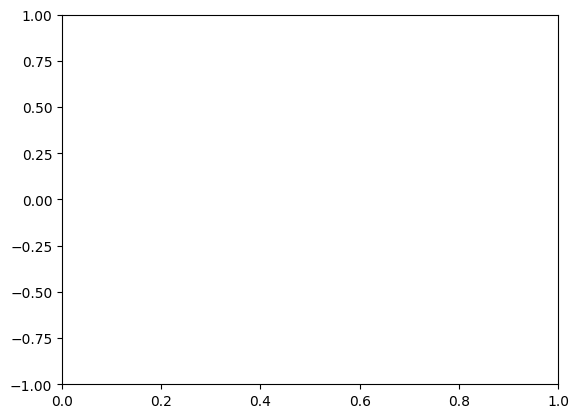

In [ ]:
from moshi_jax.moshi_jax.quantization.core_vq import EuclideanCodebook

batch_size = 1

dataloader= dataset["train.clean.360"].batch(batch_size=batch_size)

@eqx.filter_jit
@eqx.filter_value_and_grad(has_aux=True)
def calculate_losses(model, disc, x):
    y, codes, _, _ = jax.vmap(model)(x)
    # y = jnp.expand_dims(y, 1)
    fake_pred, _ = jax.vmap(disc)(y) # At what point does disc think it's a true
    G_loss = jnp.mean(jnp.abs(x-y)) * 30
    # for fake in fake_pred:
    #     G_loss += jax.numpy.mean((fake - 1) ** 2)
    # for fake_map, real_map in zip (fake_feat, real_feat):
    return G_loss, (y, codes)

@eqx.filter_jit
@eqx.filter_value_and_grad
def calc_disc_loss(disc, x, y):
    fake_pred, fake_feat = jax.vmap(disc)(y)
    real_pred, real_feat = jax.vmap(disc)(x)
    loss = 0
    for fake_res, real_res in zip(fake_pred, real_pred):
        fake_loss = jax.numpy.mean((fake_res) ** 2)
        real_loss = jax.numpy.mean((real_res - 1) ** 2)
        loss += fake_loss + real_loss
        
    return loss

@eqx.filter_jit
def update_codebook(model, codes: list, key: jax.Array=None):
    for i in range(len(model.quantizer.rvq_first.vq.layers)):
        value=EuclideanCodebook._check_expired_codes(model.quantizer.rvq_first.vq.layers[i]._codebook, codes[0][0][0], codes[0][1][0], key=key)
        model = eqx.tree_at(lambda x: x.quantizer.rvq_first.vq.layers[i]._codebook, model, value)
    for i in range(len(model.quantizer.rvq_rest.vq.layers)):
        value = EuclideanCodebook._check_expired_codes(model.quantizer.rvq_rest.vq.layers[i]._codebook, codes[i+1][0][0], codes[i+1][1][0], key=key)
        model = eqx.tree_at(lambda x: x.quantizer.rvq_rest.vq.layers[i]._codebook, model, value)
        
    return model

@eqx.filter_jit
def make_step(model, scale, optimizer, opt_state, scale_optimizer, scale_opt_state, x, key):
    (total_loss, (y, codes)), grads = calculate_losses(model, scale, x)        
    updates, opt_state = optimizer.update(grads, opt_state, eqx.filter(model, eqx.is_array))
    model = eqx.apply_updates(model, updates)
    # scale_loss, grads = calc_disc_loss(scale, x, y)
    # updates, scale_opt_state = scale_optimizer.update(grads, scale_opt_state, scale)
    # scale = eqx.apply_updates(scale, updates)
    # model = update_codebook(model, codes, key)
    
    return (
        model,
        scale,
        opt_state,
        scale_opt_state,
        total_loss,
        0,
        y
    )
    
key = jax.random.key(3)
    
fig, ax = plt.subplots(1)
ax.set_ylim(-1.0, 1.0)  # Adjust based on the expected range of your data

# fig.show()
step = 0


In [5]:
for epoch in range(epochs):
    # eqx.tree_serialise_leaves(f"checkpoints/{epoch}.eqx", model)

    for batch in dataloader:
        k1, key = jax.random.split(key)
        input = jnp.expand_dims(jnp.array(batch["audio"]), 1)
        
        model, scale_disc, opt_state, scale_opt_state, total_loss, scale_loss, y = make_step(model, scale_disc, optimizer, opt_state, scale_optimizer, scale_opt_state, input, k1)

        # Log codebook updates to TensorBoard
        step+=1
        writer.add_scalar('Loss/FSQ', total_loss, step)
        writer.add_scalar('Loss/ScaleDiscriminator', scale_loss, step)
        if (step // batch_size) % 20 == 0:
            ax.clear()
            ax.plot(input[0][0])
            ax.plot(y[0][0])
            display(fig)
            clear_output(wait=True)

KeyboardInterrupt: 

In [ ]:


print(model.quantizer.rvq_rest.vq.layers[4]._codebook.cluster_usage)

In [ ]:

coed = model.quantizer.rvq_first.vq.layers[0]._codebook

replace_cluster_usage = (
coed.replaced_usage_ratio * coed.cluster_usage / coed.codebook_size
)

print(replace_cluster_usage.shape)

In [ ]:
import jax
import librosa
import jax.numpy as jnp
y, sr = librosa.load("bria.mp3")
if sr != 24000:
    y = librosa.resample(y, orig_sr=sr, target_sr=24000)

y = jnp.array(y[None, None, :240000])
y2 = torch.Tensor(numpy.array(y))


In [ ]:
# print(y2.dtype)

out = jax.vmap(jax_model.encoder)(y)
with torch.no_grad():
    with model._context_for_encoder_decoder:
        a = model.encoder(y2)
# out2 = model.encoder(y2)
print(out[0, 0, :10])
print(a[0, 0, :10])

b = model.encoder_transformer(a)
out = jax.vmap(jax_model.encoder_transformer)(out)

print(out[0][0, 0, :10])
print(b[0][0, 0, :10])
print(out[0].shape)
c = model._to_framerate(b[0])
out = (jax.vmap(jax_model._to_framerate)(out[0]), out[1:])

print(out[0][0, 0, :10])
print(c[0, 0, :10])


In [ ]:

# out = jax.numpy.array(out2[0].detach().numpy())

d = model.quantizer(c, model.frame_rate)
out = jax.vmap(jax_model.quantizer, in_axes=(0, None))(out[0], jax_model.frame_rate)
# print(out2.x.shape)
print(out[0].shape)
e = model._to_encoder_framerate(d.x)
out = (jax.vmap(jax_model._to_encoder_framerate)(out[0]), out[1:])
# out = (jax.numpy.array(out2.x.detach().numpy()), out[1:])
# print(out2.x.shape)
print(out[0].shape)
# out = jax.numpy.array(out2[0].detach().numpy())

out = jax.vmap(jax_model.decoder_transformer)(out[0])
e = model.decoder_transformer(e)
# print("AAA")


In [ ]:


# out2 = torch.from_numpy(numpy.array(out[0]))
# out = jax.numpy.array(out2[0].detach().numpy())
# print(out2[0].shape)

with torch.no_grad():
    with model._context_for_encoder_decoder:
        f = model.decoder(e[0])
out = jax.vmap(jax_model.decoder)(out[0])

# print(out[0, 0, :10])
# print(out2[0, 0, :10])


In [ ]:
import IPython
print(y2.shape)
# IPython.display.Audio(y2[0], rate=24000)
IPython.display.Audio(out[0][0], rate=24000)

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,)
ax.plot(y[0][0][:24000])
ax.plot(out[0][0][:24000])
plt.show()

In [ ]:
import einops
codebook_size = 512
dim = 5

x = jax.random.normal(key=jax.random.key(1), shape=(10, 5))
flat_codes = jax.numpy.arange(0, 10, dtype="int64")
flat_codes = flat_codes.at[2].set(1)
print(flat_codes)
their_x = torch.from_numpy(numpy.array(x))
their_flat_codes = torch.from_numpy(numpy.array(flat_codes))
index = einops.repeat(their_flat_codes, "n -> n d", d=dim).to(torch.int64)
embedding_sum = torch.zeros((codebook_size, dim))


print(index)
print(their_x)

embedding_sum2 = jax.numpy.zeros((codebook_size, dim))
print(embedding_sum.scatter_add_(0, index, their_x))
print(embedding_sum2.at[flat_codes].add(x))